In [1]:
import io
import os
import time
import warnings

import anndata as ad
import imageio.v3 as iio
import ipywidgets as widgets
import numpy as np
import pandas as pd
import phenograph
import plotly.express as px
import plotly.graph_objects as go
import scimap as sm
import seaborn as sns
import umap
from IPython.display import clear_output, display
from PIL import Image
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import cm

# Ignore warnings
warnings.filterwarnings("ignore")

%matplotlib widget

Running SCIMAP  2.3.5


## Single-cell Analysis
This notebook provides functionallity to perform in-depth visiual and statistical single-cell analysis.  
It requires:
- single-cell data in CSV format for clustering & cluster analysis, cell distance-/neighbourhood analysis, dimensionality reduction and histogram visualisations
- Image data & segmentation masks for spatial heatmap overlay visualisations of cells and corresponding markerintensities

### Select single cell csv file and declare working directory

In [2]:
output = widgets.Output()


def on_value_change(change):
    global singlecell_df
    global PATH

    PATH = working_directory.value

    # check
    if input_file.value:
        uploaded_file = input_file.value[0]
        singlecell_df = pd.read_csv(io.BytesIO(uploaded_file.content))

        with output:
            display(singlecell_df)
            output.clear_output(wait=True)


input_file = widgets.FileUpload(
    accept=".csv",
    multiple=False,
    description="Upload single-cell CSV",
    layout={"width": "auto"},
)

working_directory = widgets.Text(
    value="",
    placeholder="Enter your working directory path",
    description="Path:",
    style={"description_width": "initial"},
)

# Observers
input_file.observe(on_value_change, names="value")
working_directory.observe(on_value_change, names="value")

display(input_file, working_directory, output)

FileUpload(value=(), accept='.csv', description='Upload single-cell CSV', layout=Layout(width='auto'))

Text(value='', description='Path:', placeholder='Enter your working directory path', style=TextStyle(descripti…

Output()

### Plot raw histogram for the selected channel
The dark-blue fitted line is a kernel density estimate which represents the smoothed distribution. 

In [48]:
df_dict = {}

# Widgets
histogram_select = widgets.Dropdown(
    options=singlecell_df.columns,
    description="Histogram channel:",
    style={"description_width": "initial"},
)
scale_select = widgets.RadioButtons(
    options=["linear", "log"],
    value="linear",
    description="Scale:",
    style={"description_width": "initial"},
)
hist_version_select = widgets.RadioButtons(
    options=list(df_dict.keys()),
    description="Histogram version",
    style={"description_width": "initial"},
)

plot_output = widgets.Output()
stats_output = widgets.Output()

# conditionally create cluster_select widget if 'cluster' column exists
if "cluster" in singlecell_df.columns:
    cluster_select = widgets.Dropdown(
        options=sorted(singlecell_df["cluster"].unique().tolist()),
        description="Cluster:",
        style={"description_width": "initial"},
    )
    # redraw
    cluster_select.observe(lambda change: update_histogram(), names="value")
else:
    cluster_select = None


# callback
def update_histogram(change=None, data=None):
    df = singlecell_df if data is None else data
    if len(df_dict) > 0:
        df = df_dict.get(hist_version_select.value, df)

    # conditioanlly apply cluster selectio
    if cluster_select is not None and "cluster" in df.columns:
        sel = cluster_select.value
        if sel is not None:
            df = df[df["cluster"] == sel]

    # redraw
    with plot_output:
        clear_output(wait=True)
        sns.displot(
            df,
            x=histogram_select.value,
            log_scale=(scale_select.value == "log"),
            kde=True,
        )
        plt.ylabel("Number of Cells")
        plt.gcf().canvas.toolbar_position = "right"
        plt.show()

    # summary statistics
    with stats_output:
        clear_output(wait=True)
        display(df[histogram_select.value].describe())


# observers
histogram_select.observe(update_histogram, names="value")
scale_select.observe(update_histogram, names="value")

# initial draw
update_histogram()


controls_and_stats = [
    histogram_select,
    widgets.HTML("<b>Channel Statistics:</b>"),
    scale_select,
    stats_output,
]
if cluster_select is not None:
    controls_and_stats.insert(0, cluster_select)


widgets.HBox([widgets.VBox(controls_and_stats), plot_output])

## Size normalisation (optional)
If present, the area of each cell is multiplied by the square of the entered pixelsize to reflect real metrics in µm² rather than arbitrary values in pixels. \
Any selected channels are divided by their respective area (after conversion into µm²). This can aid in facilitating reliable clustering results by eliminating a cell size bias.

In [ ]:
pixelsize_select = widgets.FloatText(
    value=None,
    step=0.1,
    placeholder="Pixel size in µm",
    description="Pixel size:",
    style={"description_width": "initial"},
)

normalise_channels = widgets.SelectMultiple(
    options=singlecell_df.columns,
    rows=10,
    description="Channels to normalise by size",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="auto"),
)

area_select = widgets.Dropdown(
    options=singlecell_df.columns,
    value=None,
    description="Area column:",
    style={"description_width": "initial"},
)

binary_select_norm = widgets.RadioButtons(
    options=["Yes", "No"],
    value="No",
    description="Display the modified dataframe?",
    style={"description_width": "initial"},
)

diamater_select = widgets.Dropdown(
    options=singlecell_df.columns,
    value=None,
    description="Diameter column:",
    style={"description_width": "initial"},
)

widgets.HBox(
    [
        widgets.VBox([pixelsize_select, area_select, diamater_select]),
        normalise_channels,
        binary_select_norm,
    ],
)

In [ ]:
normalised_df = singlecell_df.copy()

# Normalise features by size of cell objects
cols_to_divide = list(normalise_channels.value)
pixelsize = pixelsize_select.value
area_col = area_select.value
diameter_col = diamater_select.value

if pixelsize != 0 and area_col:
    normalised_df[area_col] = normalised_df[area_col].mul(
        float(pixelsize) ** 2
    )
    normalised_df[cols_to_divide] = normalised_df[cols_to_divide].div(
        normalised_df[area_col], axis=0
    )
    if diamater_select.value:
        normalised_df[diameter_col] = normalised_df[diameter_col].mul(
            float(pixelsize)
        )
    else:
        print("No diameter column has been set. (Optional)")

    print(
        f"{len(cols_to_divide)} channels have been normalised by '{area_col}' and pixel size of {pixelsize}µm."
    )

else:
    print(
        "Data was not size-normalised. One or more required fields are missing. Pixelsize > 0 and Area column are required."
    )

if binary_select_norm.value == "Yes":
    display(normalised_df)

## Outlier Handling (optional)
The section below provides three different approaches for handling outliers in your single-cell data:

**1. Average Percentile Rank Method** (remove_outliers_percentiles)  
This function calculates each cell's percentile rank across multiple selected features, then computes an average rank to identify outliers. By using the average rank instead of filtering on individual channels, this method ensures that cells are only removed when they consistently show extreme values across multiple features.

When to use: Ideal when you want a non-parametric approach that doesn't assume any particular data distribution.

**2. Average Z-Score Method** (remove_outliers_zscore)  
This function calculates Z-scores (standard deviations from the mean) for each value, then averages the absolute Z-scores across the selected features. Cells with average Z-scores exceeding your threshold are considered outliers.

When to use: Best for data that approximately follows a normal distribution. The threshold n_std determines how strict the filtering is - typically values of 2-3 are used.

**3. Individual Thresholds Method** (individual_thresholds)  
Unlike the above methods which exclude entire cells, this function allows you to set specific min/max thresholds for each channel independently. Values above or below these thresholds are clipped to mathc the set range rather than removing the entire cell.

When to use: When you want to clean specific channel values without losing entire cells, or when different channels require different threshold strategies.

In [ ]:
# Remove outliers based on the average percentile rank across multiple columns
def remove_outliers_percentiles(df, columns, upper_quant, lower_quant):
    ranks_df = pd.DataFrame()
    for col in columns:
        # convert to percentile rank
        ranks_df[f"{col}_rank"] = df[col].rank(pct=True)

    ranks_df["avg_rank"] = ranks_df.mean(axis=1)
    mask = (ranks_df["avg_rank"] >= lower_quant) & (ranks_df["avg_rank"] <= upper_quant)

    non_outliers = df[mask]
    outliers = df[~mask]

    return non_outliers, outliers


# Remove outliers based on the average absolute Z-score across multiple columns
def remove_outliers_zscore(df, columns, n_std):
    z_scores_df = pd.DataFrame()
    for col in columns:
        z_scores_df[f"{col}_z"] = (df[col] - df[col].mean()) / df[col].std()

    abs_z_scores_df = z_scores_df.abs()
    abs_z_scores_df["avg_abs_z"] = abs_z_scores_df.mean(axis=1)
    mask = abs_z_scores_df["avg_abs_z"] <= n_std

    non_outliers = df[mask]
    outliers = df[~mask]

    return non_outliers, outliers


# Clip values to [min, max]
def individual_thresholds(df, threshold_widgets):
    original = df.copy()
    clipped = df.copy()
    outlier_mask = pd.Series(False, index=df.index)

    for ch, w in threshold_widgets.items():
        if ch not in df.columns:
            print(f"Warning: '{ch}' not in DataFrame—skipping")
            continue
        lo, hi = w["min"].value, w["max"].value

        below = clipped[ch] < lo
        above = clipped[ch] > hi

        # record changed rows
        outlier_mask |= below | above

        # clipping
        clipped.loc[below, ch] = lo
        clipped.loc[above, ch] = hi

    outliers_df = original[outlier_mask].copy()
    return clipped, outliers_df


if "normalised_df" in locals():
    data_to_filter = normalised_df.copy()
    print(
        "Data was previously size-normalised. Filtering outliers from normalised data!"
    )
else:
    data_to_filter = singlecell_df.copy()
    print(
        "Data was not size-normalised. Filtering/Thresholding performed on original data!"
    )

In [ ]:
filter_channels = widgets.SelectMultiple(
    options=singlecell_df.columns,
    rows=10,
    description="Channels",
    style={"description_width": "initial"},
)
binary_select_filter = widgets.RadioButtons(
    options=["Yes", "No"],
    value="No",
    description="Do you wish to display the modified dataframe?",
    style={"description_width": "initial"},
)
outlier_method = widgets.RadioButtons(
    options=["Percentiles", "Z-Score", "Individual Thresholds"],
    description="Outlier Method:",
    disabled=False,
)
n_std_select = widgets.FloatText(
    step=0.1,
    description="Number of standard deviations:",
    style={"description_width": "initial"},
)
upper_quant_select = widgets.FloatText(
    step=0.001,
    description="Upper percentile limit:",
    style={"description_width": "initial"},
)
lower_quant_select = widgets.FloatText(
    step=0.001,
    description="Lower percentile limit:",
    style={"description_width": "initial"},
)

In [ ]:
# Threshold widgets container
individual_thresholds_container = widgets.Output()
last_update_time = 0

def update_display(trigger=None):
    global last_update_time
    now = time.time()
    if trigger!="channel_selection" and now - last_update_time < 0.2:
        return
    last_update_time = now

    with individual_thresholds_container:
        individual_thresholds_container.clear_output(wait=True)
        if outlier_method.value=="Individual Thresholds":
            create_threshold_ui()

threshold_widgets = {}

def create_threshold_ui():
    channels = list(filter_channels.value)
    if not channels:
        print("Please select channels first")
        return

    # fixed layouts
    name_l  = widgets.Layout(width="200px")
    field_l = widgets.Layout(width="150px")
    style   = {"description_width":"initial"}

    # headers
    hdr = [
        widgets.HTML("<b>Channel</b>"),
        widgets.HTML("<b>Min</b>"),
        widgets.HTML("<b>Max</b>")
    ]
    grid_children = hdr.copy()

    for ch in channels:
        vals = singlecell_df[ch]
        min_w = widgets.FloatText(value=vals.min(), step=0.001,
                                  layout=field_l, style=style)
        max_w = widgets.FloatText(value=vals.max(), step=0.001,
                                  layout=field_l, style=style)
        lbl = widgets.HTML(f"<b>{ch}</b>", layout=name_l)

        threshold_widgets[ch] = {"min":min_w, "max":max_w}
        grid_children.extend([lbl, min_w, max_w])

    grid = widgets.GridBox(
        children=grid_children,
        layout=widgets.Layout(
            grid_template_columns="200px 150px 150px",
            grid_gap="10px 10px"
        )
    )

    display(widgets.HTML("<h3>Per-Channel Thresholds</h3>"))
    display(grid)

# observers
outlier_method.observe(lambda c: update_display("method_change"), names="value")
filter_channels.observe(lambda c: update_display("channel_selection"), names="value")

# display
display(widgets.VBox([
    widgets.HBox([filter_channels, outlier_method, binary_select_filter]),
    widgets.HBox([n_std_select, upper_quant_select, lower_quant_select])
]))
display(individual_thresholds_container)
update_display("initial")

In [ ]:
columns_to_filter = list(filter_channels.value)

try:
    if not columns_to_filter:
        print("No channels selected for filtering!")
    else:
        if outlier_method.value == "Percentiles":
            filtered_df, outliers_df = remove_outliers_percentiles(
                data_to_filter,
                columns_to_filter,
                float(upper_quant_select.value),
                float(lower_quant_select.value),
            )
            print(
                str(len(outliers_df))
                + " cell events were filtered out using percentiles and stored in `outliers_df`!"
            )
        elif outlier_method.value == "Z-Score":
            filtered_df, outliers_df = remove_outliers_zscore(
                data_to_filter, columns_to_filter, float(n_std_select.value)
            )
            print(
                str(len(outliers_df))
                + " cell events were filtered out using z-score and stored in `outliers_df`!"
            )
        else:
            filtered_df, outliers_df = individual_thresholds(
                data_to_filter, threshold_widgets
            )
            print(f"{len(outliers_df)} rows were modified using thresholds!")
except Exception as e:
    filtered_df = data_to_filter.copy()
    print(f"An error occurred during filtering: {e}. Using original data!")


if binary_select_filter.value == "Yes":
    display(filtered_df)

##### Uncomment cell below to save filtered data as CSV (e.g. for quantification) 

In [ ]:
# filtered_df.to_csv(os.path.join(PATH, 'filtered.csv'), index=False)

### Plot normalised and or filtered histogram for the selected channel

In [ ]:
df_dict["Original data"] = singlecell_df.copy()

if "normalised_df" in locals() and "filtered_df" in locals():
    df_dict["Normalised data"] = normalised_df
    df_dict["Filtered data"] = filtered_df
elif "normalised_df" in locals():
    df_dict["Normalised data"] = normalised_df
elif "filtered_df" in locals():
    df_dict["Filtered data"] = filtered_df
else:
    print(
        "Neither size normalisation nor outlier filtering was performed. Only original data is available to plot a histogram!"
    )

# Create an Output widget
plot_output = widgets.Output()

# Update the observe function to reference update_hist_version
histogram_select.observe(update_histogram, names="value")
hist_version_select.observe(update_histogram, names="value")
scale_select.observe(update_histogram, names="value")

update_histogram()

# Display
widgets.HBox(
    [
        widgets.VBox([histogram_select, scale_select, stats_output]),
        hist_version_select,
        plot_output,
    ]
)

## IMPORTANT: Checking which version of the data is present
*(original/size-normalised/outlier filtered/combination)* \
This cell needs to be executed before continuing!

In [3]:
if "filtered_df" in locals():
    print(
        "Data was outlier filtered. Filtered data will be used for downstream analysis!"
    )
elif "normalised_df" in locals():
    print(
        "Data was not outlier filtered but normalised by size. Using size-normalised data for downstream analysis!"
    )
    filtered_df = normalised_df.copy()
else:
    print(
        "Data was neither size-normalised nor outlier filtered. Using original data for downstream analysis!"
    )
    filtered_df = singlecell_df.copy()

Data was neither size-normalised nor outlier filtered. Using original data for downstream analysis!


## Plot a heatmap for the selected channel overlayed on a raw image
When executed this cell will produce an interactive single-cell/object mask layered on-top of a raw image. Colours are mapped to indicate channel intensity. \
Upload a .png segmentation mask of your cells/objects and your raw or processed (increasing contrast can greatly improve visability) sample image. Select the channel you wish to visualise and click the 'Load data and visualise' button. \
Move the 'Intensity range'-slider to adjust upper and lower thresholds for the channel intensity. \
Move the 'Opacity'-slider to adjust the opacity of the overlayed cell-/object mask.  
  
To add ROIs, select the lasso tool and simply draw on the segmentation mask. Entering a name for the ROI and clicking the 'Save'-button will export the cells within the ROI as a CSV named accordingly.  
Multiple selections can be concetenated into one ROI by pressing and holding **'Shift'** for any subsequent selection after the initial one.  
Additionbally, cells can be part of up to 3 ROIs (levels) at once. Edit ```max_levels = 3``` and ```roi_cols = ["ROI", "secondary ROI", "tertiary ROI"]``` to extend or limit the levels of ROIs.

**NOTE**:  
This plotting function relies on a **"cell_label"**-column contained in the single-cell CSV to correctly index the individual cells. This entry is automatically included if the single-cell data was extracted using the **data_extraction notebook**.  
If this was not the case, please adjust all occurance of **"cell_label"** in the next cell but one (nameley lines: 61, 193, 230 and 264).  
Visualising **"cell_label"** (or it's replacement value) from the dropdown selection is not supported and will produce an error.  
Adjust the ```MAX_DISPLAY_WIDTH``` variable on line 1 of the cell below to accomodate for your maximum screen resolution *minus* extra space for the colourbar (~500px at WHQD resolution).  
This is only necessary if your image appears cut off meaning the image width in pixels is close to your displays maximum horizontal resolution.  

In [49]:
MAX_DISPLAY_WIDTH = 1850

# Widgets
background_uploader = widgets.FileUpload(
    accept="image/*",
    multiple=False,
    description="Background Image",
    layout=widgets.Layout(width="auto"),
)
mask_uploader = widgets.FileUpload(
    accept="image/*",
    multiple=False,
    description="Segmentation Mask",
    layout=widgets.Layout(width="auto"),
)
channel_dropdown = widgets.Dropdown(
    description="Channel",
    options=filtered_df.columns,
    value=None,
)
op_slider = widgets.FloatSlider(
    value=0.6,
    min=0.05,
    max=1.0,
    step=0.05,
    description="Opacity",
    style={"description_width": "initial"},
    continuous_update=False,
)
range_slider = widgets.FloatRangeSlider(
    description="Intensity range",
    style={"description_width": "initial"},
    disabled=True,
    continuous_update=False,
)
name_text = widgets.Text(placeholder="Selection", description="Save as")
save_btn = widgets.Button(description="Save", button_style="info", disabled=True)
selection_out = widgets.Output()
output_area = widgets.Output()
ui = widgets.VBox(
    [
        widgets.HBox([background_uploader, mask_uploader]),
        widgets.HBox([channel_dropdown, op_slider, range_slider]),
        widgets.HBox([name_text, save_btn]),
        selection_out,
        output_area,
    ]
)
ui_out1 = widgets.Output()  # first cell output area
ui_out2 = widgets.Output()  # second cell output area

In [50]:
# Initially render
with ui_out1:
    display(ui)
display(ui_out1)

# State variables
last_selected = []
saved_select = {}
saved_traces = {}
palette = px.colors.qualitative.Plotly


# Helpers
def _prep_background(bg: np.ndarray) -> Image.Image:
    arr = bg.copy()

    # dtype handling
    if arr.dtype.kind == "f":  # float32/64
        peak = np.nanmax(arr) or 1.0
        arr = np.clip(arr / peak * 255, 0, 255).astype(np.uint8)
    elif arr.dtype.kind in "ui" and (
        arr.dtype.itemsize > 1 or arr.max() > 255
    ):  # >8‑bit int
        peak = arr.max() or 1
        arr = (arr / peak * 255).astype(np.uint8)

    # channel handling
    if arr.ndim == 2:  # gray to RGB
        arr = np.stack([arr] * 3, axis=-1)
    elif arr.shape[-1] == 4:  # drop alpha
        arr = arr[..., :3]

    return Image.fromarray(arr)


def _save_selection(_):
    with selection_out:
        selection_out.clear_output(wait=True)

        # validate inputs
        name = name_text.value.strip()
        if not name:
            print("Please enter a name for the selection first.")
            return
        if not last_selected:
            print("No selection to save.")
            return
        if name in saved_select:
            print(f"A selection called “{name}” already exists.")
            return

        # ROI tagging parameters
        max_levels = 3
        roi_cols = ["ROI", "secondary ROI", "tertiary ROI"]

        # ensure primary ROI exists
        if roi_cols[0] not in filtered_df.columns:
            filtered_df[roi_cols[0]] = None

        # build selection mask
        sel_mask = filtered_df["cell_label"].isin(last_selected)
        remaining = sel_mask.copy()

        # tag up to max_levels
        for level, col in enumerate(roi_cols, start=1):
            if level > 1 and col not in filtered_df.columns:
                filtered_df[col] = None
            can_assign = remaining & filtered_df[col].isna()
            filtered_df.loc[can_assign, col] = name
            remaining = remaining & ~can_assign
            if not remaining.any():
                break

        if remaining.any():
            n_exceeded = int(remaining.sum())
            print(
                f"Warning: {n_exceeded} row(s) already tagged at all "
                f"{max_levels} ROI levels; cannot tag further."
            )

        # slice & cache selection
        sub_df = filtered_df.loc[sel_mask].copy()
        saved_select[name] = sub_df

        # build/add scatter trace
        colour = palette[len(saved_traces) % len(palette)]
        centroids = _build_centroids(_get_cached(mask_uploader, "mask"))
        coords = centroids.loc[last_selected]

        sel_trace = go.Scattergl(
            x=coords.x,
            y=coords.y,
            mode="markers",
            marker=dict(size=6, symbol="circle", color=colour, line=dict(width=2)),
            name=name,
            showlegend=True,
            meta={"saved": True},
        )
        _fig.add_trace(sel_trace)
        saved_traces[name] = sel_trace

        # export to CSV
        filepath = os.path.join(PATH, f"{name}.csv")
        sub_df.to_csv(filepath, index=False)

        save_btn.disabled = True
        name_text.value = ""
        total = len(sub_df)
        print(f"Saved “{name}” with {total} rows (up to {max_levels} ROI levels).")
        display(sub_df.head())


# lasso callback
def _on_sel(trace, pts, selector):
    with selection_out:
        selection_out.clear_output(wait=True)

        idx = pts.point_inds
        trace.selectedpoints = idx or None

        if not idx:
            last_selected.clear()
            save_btn.disabled = True
            print("No cells selected.")
            return

        labels = trace.customdata[idx, 0].astype(int).tolist()
        last_selected[:] = labels
        save_btn.disabled = False

        vals = trace.customdata[idx, 1]
        print(f"{len(labels)} cells selected on “{current_channel}”.")
        print(f"  min / max {current_channel}: {vals.min():.3g} / {vals.max():.3g}")
        print("  first IDs:", labels[:10], "…" if len(labels) > 10 else "")


# Main callback
_img_cache, _int_cache, _centroid_cache, _fig, last_channel = {}, {}, {}, None, None


def _get_cached(upl, key):
    if key not in _img_cache:
        _img_cache[key] = iio.imread(upl.value[0]["content"])
    return _img_cache[key]


def _build_centroids(mask):
    if "xy" in _centroid_cache:
        return _centroid_cache["xy"]
    ys, xs = np.nonzero(mask)
    df = pd.DataFrame({"x": xs, "y": ys, "lbl": mask[ys, xs]})
    cent = df.groupby("lbl")[["x", "y"]].mean().astype(int)
    cent = cent[cent.index != 0]  # drop background
    _centroid_cache["xy"] = cent
    return cent


def _render(full_update=True):
    global _fig, last_channel, current_channel

    # fast opacity‐only update
    if not full_update and _fig is not None:
        _fig.layout.images[1].opacity = op_slider.value
        return

    # load background + mask
    try:
        bg = _get_cached(background_uploader, "bg")
        mask = _get_cached(mask_uploader, "mask")
    except (ValueError, IndexError):
        with output_area:
            clear_output()
            print("Upload images first.")
        return

    # channel selection
    channel_dropdown.options = filtered_df.columns
    ch = channel_dropdown.value or ""
    current_channel = ch
    if ch == "":
        with output_area:
            clear_output()
            print("Pick a channel")
        return

    H, W = mask.shape
    disp_w = min(MAX_DISPLAY_WIDTH, W)
    disp_h = int(disp_w * (H / W))

    # categorical branch
    if ch == "cluster":
        # build float mask
        lut = filtered_df.set_index("cell_label")[ch].to_dict()
        labels = np.full(mask.shape, np.nan, dtype=float)
        for cid, val in lut.items():
            labels[mask == cid] = float(val)

        uniq = np.unique(labels[~np.isnan(labels)]).astype(int)
        cmap = plt.get_cmap("tab20", len(uniq))

        # RGBA overlay
        rgba = np.zeros(mask.shape + (4,), dtype=np.uint8)
        for idx, lbl in enumerate(uniq):
            col = (np.array(cmap(idx)[:3]) * 255).astype(np.uint8)
            rgba[labels == lbl, :3] = col
            rgba[labels == lbl, 3] = 255
        overlay = Image.fromarray(rgba, mode="RGBA")

        # centroids + hover
        cent = _build_centroids(mask)
        cent["cluster"] = cent.index.to_series().map(lut.get)
        hovertemplate = (
            "cell %{customdata[0]}<br>cluster: %{customdata[1]}<extra></extra>"
        )

        cb_args = None

        # prepare legend‐color mapping
        legend_colors = {
            lbl: tuple((np.array(cmap(i)[:3]) * 255).astype(int))
            for i, lbl in enumerate(uniq)
        }

    # continuous branch
    else:
        # intensity caching
        if ch in _int_cache:
            inten = _int_cache[ch]
        else:
            lut = filtered_df.set_index("cell_label")[ch].to_dict()
            table = np.full(mask.max() + 1, np.nan, dtype=float)
            for cid, val in lut.items():
                if cid < table.size:
                    table[cid] = val
            inten = table[mask]
            _int_cache[ch] = inten

        if np.all(np.isnan(inten)):
            with output_area:
                clear_output()
                print("No matching labels.")
            return

        nz = inten[~np.isnan(inten)]
        imin, imax = float(nz.min()), float(nz.max())

        # update range slider
        if range_slider.disabled:
            range_slider.disabled = False
        range_slider.min, range_slider.max = imin, imax
        if ch != last_channel:
            range_slider.value = (imin, imax)
        zmin, zmax = range_slider.value
        last_channel = ch

        # RGBA overlay
        norm = np.clip((inten - zmin) / (zmax - zmin), 0, 1)
        rgba = (cm.get_cmap("viridis")(norm) * 255).astype(np.uint8)
        rgba[..., 3] = 255
        rgba[np.isnan(norm)] = [0, 0, 0, 0]
        overlay = Image.fromarray(rgba, mode="RGBA")

        # hover
        val_map = filtered_df.set_index("cell_label")[ch].to_dict()
        cent = _build_centroids(mask)
        cent["val"] = cent.index.to_series().map(val_map.get)
        hovertemplate = (
            f"cell %{{customdata[0]}}<br>{ch}: %{{customdata[1]:.3g}}<extra></extra>"
        )

        # continuous‐colorbar
        cb_args = dict(
            x=[W, W],
            y=[H, H],
            mode="markers",
            marker=dict(
                color=[zmin, zmax],
                colorscale="Viridis",
                cmin=zmin,
                cmax=zmax,
                showscale=True,
                colorbar=dict(
                    len=0.7,
                    y=0.5,
                    tickfont=dict(color="white"),
                    title_font=dict(color="white")
                ),
                size=0,
            ),
            hoverinfo="none",
            showlegend=False,
            name=None,
        )

        legend_colors = {}

    # remove extra traces
    def _purge_extra_traces():
        new_data = []

        # keep background/overlay + colourbar
        new_data.extend(_fig.data[:1])

        # keep saved traces
        for tr in _fig.data[1:]:
            meta = tr.meta if isinstance(tr.meta, dict) else {}
            if meta.get("saved", False):
                new_data.append(tr)

        _fig.data = tuple(new_data)

    # build vs. update figure
    if _fig is None:
        with output_area:
            clear_output()
            _fig = go.FigureWidget(
                layout=dict(
                    width=disp_w,
                    height=disp_h,
                    margin=dict(l=0, r=0, t=0, b=0),
                    dragmode="lasso",
                    uirevision="keep",
                )
            )
            _fig.update_layout(
                paper_bgcolor="black",
                plot_bgcolor="black",
                font=dict(color="white"),
                legend=dict(
                    font=dict(color="white"),
                    itemsizing="constant",
                    title_text="Clusters",
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="left",
                    x=0,
                ),
            )

            # background + overlay
            for src, layer in ((_prep_background(bg), "below"), (overlay, "above")):
                _fig.add_layout_image(
                    dict(
                        source=src,
                        x=0,
                        y=0,
                        sizex=W,
                        sizey=H,
                        layer=layer,
                        xref="x",
                        yref="y",
                        opacity=(op_slider.value if layer == "above" else 1),
                    )
                )

            # centroid scatter
            sc = go.Scattergl(
                x=cent.x,
                y=cent.y,
                mode="markers",
                marker=dict(size=3, opacity=0),
                customdata=np.stack(
                    [cent.index, cent["cluster"] if ch == "cluster" else cent["val"]], 1
                ),
                hovertemplate=hovertemplate,
                selected=dict(marker=dict(opacity=1, size=6, color="white")),
                unselected=dict(marker=dict(opacity=0)),
                showlegend=False,
            )
            _fig.add_trace(sc)
            _fig.data[0].on_selection(_on_sel)

            # continuous colorbar
            if cb_args:
                _fig.add_trace(go.Scatter(**cb_args))

            # cluster legend entries
            if legend_colors:
                for lbl, rgb in legend_colors.items():
                    rgba_str = f"rgba({rgb[0]},{rgb[1]},{rgb[2]},255)"
                    _fig.add_trace(
                        go.Scatter(
                            x=[None],
                            y=[None],
                            mode="markers",
                            marker=dict(color=rgba_str, size=6),
                            name=str(lbl),
                            showlegend=True,
                        )
                    )

            _fig.update_xaxes(visible=False, range=[0, W], scaleanchor="y")
            _fig.update_yaxes(visible=False, range=[H, 0])

            display(_fig)

    else:
        # update in‐place
        _fig.layout.width = disp_w
        _fig.layout.height = disp_h
        _fig.layout.images[0].source = _prep_background(bg)
        _fig.layout.images[1].source = overlay
        _fig.layout.images[1].opacity = op_slider.value

        # scatter coords + hover (no legend)
        sc = _fig.data[0]
        sc.x, sc.y = cent.x, cent.y
        sc.customdata = np.stack(
            [cent.index, cent["cluster"] if ch == "cluster" else cent["val"]], 1
        )
        sc.hovertemplate = hovertemplate
        sc.showlegend = False

        # purge old extra traces
        _purge_extra_traces()

        # continuous‐colorbar
        if cb_args:
            _fig.add_trace(go.Scatter(**cb_args))

        # cluster legend entries
        if legend_colors:
            for lbl, rgb in legend_colors.items():
                rgba_str = f"rgba({rgb[0]},{rgb[1]},{rgb[2]},255)"
                _fig.add_trace(
                    go.Scatter(
                        x=[None],
                        y=[None],
                        mode="markers",
                        marker=dict(color=rgba_str, size=6),
                        name=f"Cluster {lbl}",
                        showlegend=True,
                    )
                )

        # show legend only for cluster
        _fig.update_layout(showlegend=(ch == "cluster"))
        _fig.layout.images[1].opacity = op_slider.value


# Event wiring
def _on_opacity(change):
    _render(full_update=False)


def _on_other(change):
    _render(full_update=True)


save_btn.on_click(_save_selection)
op_slider.observe(_on_opacity, names="value")
for w in (channel_dropdown, range_slider):
    w.observe(_on_other, names="value")

Output()

### Hyperlink: Spatial distance and interactions analysis
This is a hyperlink to jump back up down to the spatial distance and interactions analysis section.  
[Click to jump to spatial distance and interactions analysis](#Spatial-distance-and-interactions-analysis)

## Clustering

### Select channels for clustering
**Note:** If data was previously size-normalised it is recommended to leave morphological features unselected

In [8]:
cluster_channels = widgets.SelectMultiple(
    options=filtered_df.columns,
    rows=20,
    description="Channels",
    style={"description_width": "initial"},
)

display(cluster_channels)

SelectMultiple(description='Channels', options=('cell_label', 'Center_Y', 'Center_X', 'Area', 'Diameter', 'Ant…

### Select a scaling method (comment/uncomment)
Standardize data values to bring them onto a comparable scale. This facilitates accurate clustering results. \
Two methods are available: Robust scaling and MinMax scaling \
For more information on data scaling see [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) and [here](https://scikit-learn.org/stable/modules/preprocessing.html)

In [9]:
# Widgets
scaling_output = widgets.Output()

scaling_method = widgets.RadioButtons(
    options=["arcsinh", "robust", "minmax"],
    description="Scaling Method:",
    style={"description_width": "initial"},
)

display_scaling = widgets.Checkbox(
    value=False, description="Show head of scaled data", style={"description_width": "initial"}
)


# Update scaling based on selections
def update_scaling(*args):
    with scaling_output:
        scaling_output.clear_output(wait=True)
        if not list(cluster_channels.value):
            print("Please select channels to scale first")
            return

        try:
            global scaled_df
            if scaling_method.value == "arcsinh":
                arcsinh_scaler = np.arcsinh
                scaled_df = filtered_df.copy()
                scaled_df[list(cluster_channels.value)] = arcsinh_scaler(
                    filtered_df[list(cluster_channels.value)] / 5
                )
                print(
                    f"Arcsinh(x/5) scaling applied to {len(cluster_channels.value)} channels"
                )

            elif scaling_method.value == "robust":
                r_scaler = preprocessing.RobustScaler()
                r_scaled = r_scaler.fit_transform(
                    filtered_df.loc[:, list(cluster_channels.value)]
                )

                scaled_df = filtered_df.copy()
                scaled_df[list(cluster_channels.value)] = r_scaled
                print(
                    f"Robust scaling applied to {len(cluster_channels.value)} channels"
                )

            elif scaling_method.value == "minmax":
                mm_scaler = preprocessing.MinMaxScaler()
                mm_scaled = mm_scaler.fit_transform(
                    filtered_df.loc[:, list(cluster_channels.value)]
                )

                scaled_df = filtered_df.copy()
                scaled_df[list(cluster_channels.value)] = mm_scaled
                print(
                    f"MinMax scaling applied to {len(cluster_channels.value)} channels"
                )

            if display_scaling.value:
                display(scaled_df[list(cluster_channels.value)].head())

        except Exception as e:
            print(f"Error during scaling: {e}")


# Observers
scaling_method.observe(update_scaling, names="value")
display_scaling.observe(update_scaling, names="value")

controls = widgets.VBox([scaling_method, display_scaling])

# Display
display(controls)
display(scaling_output)

update_scaling()

Output()

### PhenoGraph clustering

For information on the usage and parameters of PhenoGraph please refer to https://github.com/dpeerlab/phenograph  
and or read the corresponding publications: Jacob H. Levine et al., __[Phenograph](https://doi.org/10.1016/j.cell.2015.05.047)__ and V. A. Traag et al., __[Leiden algorithm](https://doi.org/10.1038/s41598-019-41695-z)__;  
Before clustering, make sure you are only including the desired channels (see cell above);  
  
**Note:** Leaving the 'Initial seed' parameter unset will result in a random starting seed and therefore will lead to slightly different results each run

In [46]:
resolution_parameter_text = widgets.Text(
    value="",
    placeholder="1.0",
    description="resolution parameter:",
    style={"description_width": "initial"},
)

k_text = widgets.Text(
    value="",
    placeholder="30",
    description="k-value:",
    style={"description_width": "initial"},
)

seed_text = widgets.Text(
    value="",
    placeholder="42",
    description="initial seed:",
    style={"description_width": "initial"},
)

update_button = widgets.Button(
    description="Run Clustering",
    layout={"width": "max-content"},
)

output_widget = widgets.Output()


# Callback
def run_clustering(button):
    global communities, graph, Q

    try:
        k = int(k_text.value)
    except ValueError:
        print("Invalid k-value. Please enter an integer.")
        return

    try:
        resolution_parameter = float(resolution_parameter_text.value)
    except ValueError:
        print("Invalid resolution parameter. Please enter a float.")
        return

    try:
        seed = None if seed_text.value == "" else int(seed_text.value)
    except ValueError:
        print("Invalid seed. Please enter an integer or leave it empty.")
        return

    with output_widget:
        output_widget.clear_output()
        communities, graph, Q = phenograph.cluster(
            scaled_df[list(cluster_channels.value)],
            clustering_algo="leiden",
            k=k,
            resolution_parameter=resolution_parameter,
            seed=seed,
        )
        print(
            f"Clusters: {communities.max() + 1} \nModularity score: Q = {Q:.4f}"
        )

        # update filtered_df
        filtered_df["cluster"] = pd.Categorical(communities)


update_button.on_click(run_clustering)

# Display
widgets.VBox(
    [
        k_text,
        resolution_parameter_text,
        seed_text,
        update_button,
        output_widget,
    ]
)

## Dimensionality reduction using UMAP
Run and visualise UMAP embedding;<br>
Default settings for UMAPs hyperparemeters are used. If you wish to finetune UMAPs parameters, uncomment and execute the collapsed cell below. <br>
For information on the usage and parameters of UMAP please refer to the documentation https://umap-learn.readthedocs.io/en/latest/index.html<br>
and or read the corresponding publication: Jacob H. Levine et al., https://doi.org/10.48550/arXiv.1802.03426;<br>
<br>
**Note:** UMAP will be excuted using default parameters. To set a random state (for reproducible results) or change other parameters, uncomment the code below line 5 in the cell below and edit the parameters.

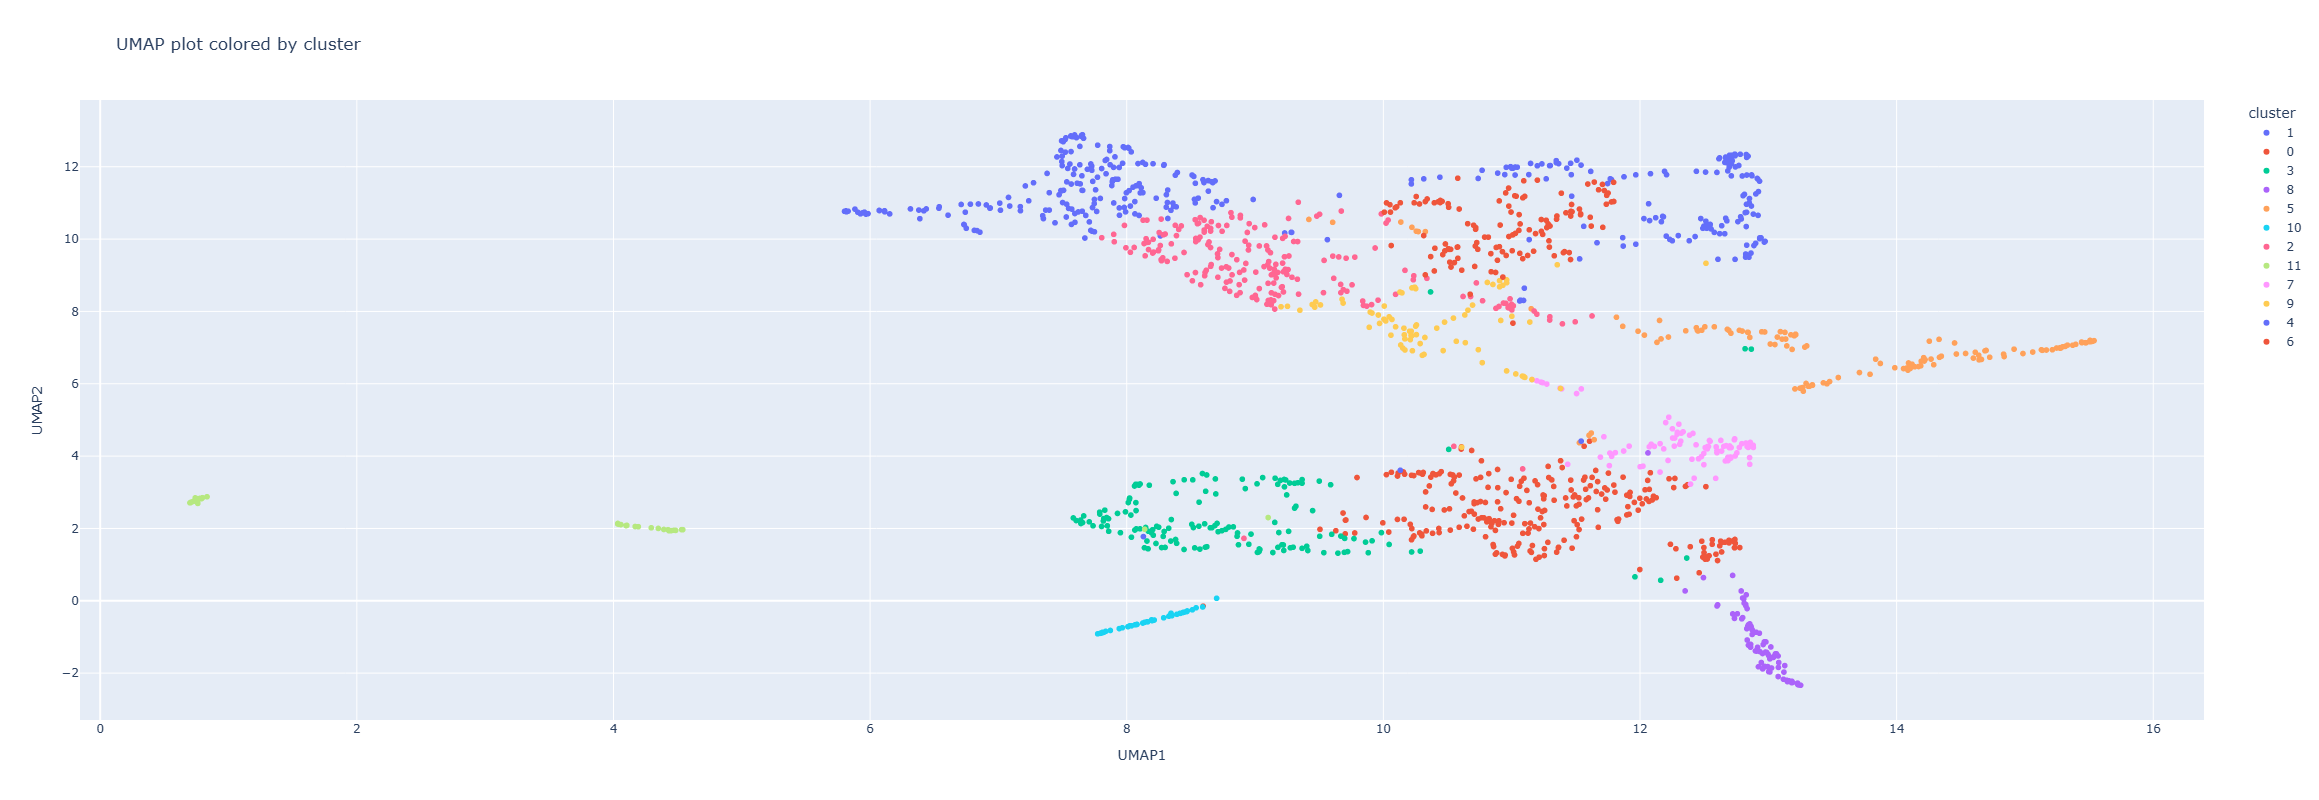

In [40]:
# UMAP embedding
reducer = umap.UMAP()

# UMAP with hyperparameters
# Uncomment the following lines to use specific parameters
# reducer = umap.UMAP(
#     n_neighbors=30,
#     min_dist=0.3,
#     metric="euclidean",
#     random_state=42,
# )

embedding = reducer.fit_transform(scaled_df[list(cluster_channels.value)])
embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
# add cluster column
embedding_df["cluster"] = pd.Categorical(
    communities, ordered=True, categories=sorted(set(communities))
)

# plot embedding
fig = px.scatter(
    embedding_df,
    x="UMAP1",
    y="UMAP2",
    color="cluster",
    hover_data=[embedding_df.index],
    color_continuous_scale="jet",
    title="UMAP plot colored by cluster",
    width=1000,
    height=800,
)

fig.show(renderer='jupyterlab')

## Cluster analysis using a cluster heatmap
The section is used to create a heatmap of the previously generated clusters. This can aide in phenotyping cells or distinguishing whole tissue areas.
The heatmap is generated in the following way:

1. The mean or median of each channel for every cluster is calculated.
2. Channel Z-scores (the number of standard deviations from the mean) are calculated for each cluster.
3. Z-scores are visualised as coloured squares ranging from blue (negative deviation) to red (positive deviation).

In [51]:
# Widgets
heatmap_channels = widgets.SelectMultiple(
    options=filtered_df.columns,
    rows=20,
    description="Channels:",
    style={"description_width": "initial"},
)

stats_method = widgets.RadioButtons(
    options=["Median", "Mean"],
    value="Median",
    description="Statistical method:",
    style={"description_width": "initial"},
)

profile_output = widgets.Output()


def generate_cluster_profiles(method="Median", selected_channels=None):
    if "filtered_df" not in globals() or "cluster" not in filtered_df.columns:
        return (
            pd.DataFrame(),
            pd.DataFrame(),
            None,
            "Error: No clustering data available.",
        )

    cluster_sizes = filtered_df["cluster"].value_counts().sort_index()

    if selected_channels and len(selected_channels) > 0:
        columns_to_use = selected_channels
    else:
        columns_to_use = filtered_df.select_dtypes(include=["number"]).columns

    if method == "Median": # median
        profiles = filtered_df.groupby("cluster")[columns_to_use].median()
    else:  # mean
        profiles = filtered_df.groupby("cluster")[columns_to_use].mean()

    # Z-score scaling
    z_scaler = preprocessing.StandardScaler()
    z_scaled = z_scaler.fit_transform(profiles)
    heatmap_clusters = pd.DataFrame(
        z_scaled, columns=profiles.columns, index=profiles.index
    )

    # Return profiles, Z-scaled profiles, and cluster sizes
    return (
        profiles,
        heatmap_clusters,
        cluster_sizes,
        f"Created profiles for {len(cluster_sizes)} clusters using {method.lower()} of {len(columns_to_use)} channels",
    )


def draw_heatmap(change=None):
    with profile_output:
        profile_output.clear_output(wait=True)
        method = stats_method.value
        selected_channels = list(heatmap_channels.value)

        # profiles
        raw_profiles, heatmap_clusters, cluster_sizes, message = (
            generate_cluster_profiles(
                method=method, selected_channels=selected_channels
            )
        )

        if raw_profiles.empty:
            print(message)
            return

        # Store results
        global cluster_profiles, cluster_heatmap
        cluster_profiles = raw_profiles
        cluster_heatmap = heatmap_clusters

        print(message)

        # figure with two y-axes
        fig, ax1 = plt.subplots(figsize=(12, max(6, len(cluster_sizes) * 0.4)))
        sns.heatmap(heatmap_clusters, cmap="bwr", center=0, ax=ax1)
        ax1.set_xticks(np.arange(heatmap_clusters.shape[1]) + 0.5)  # Center ticks
        xticklabels = ax1.set_xticklabels(heatmap_clusters.columns, rotation=45)

        for label in xticklabels:
            label.set_horizontalalignment("right")
            label.set_verticalalignment("top")
            label.set_rotation_mode("anchor")

        # adjust font size if too many labels
        if len(selected_channels) > 35:
            fontsize = 6
        else:
            fontsize = 10

        for label in ax1.get_xticklabels():
            label.set_fontsize(fontsize)

        ax1.set_title(f"Cluster Profiles ({method})")
        ax1.set_xlabel("Channels")
        ax1.set_ylabel("Cluster")

        # second y-axis for cluster sizes
        ax2 = ax1.twinx()
        ax2.set_yticks(np.arange(len(cluster_sizes)) + 0.5)
        ax2.set_yticklabels(cluster_sizes.values, fontsize=8)
        ax2.set_ylabel("Cluster Size")
        ax2.set_ylim(ax1.get_ylim())
        ax2.tick_params(axis="y", length=0)
        ax1.grid(False)
        ax2.grid(False)

        plt.tight_layout(rect=[0, 0, 0.95, 1])
        plt.show()


# Observers
heatmap_channels.observe(draw_heatmap, names="value")
stats_method.observe(draw_heatmap, names="value")

display(widgets.HBox([heatmap_channels, widgets.VBox([stats_method, profile_output])]))

# Initial update
if heatmap_channels.value:
    draw_heatmap()
else:
    with profile_output:
        print("Please select channels to generate the heatmap.")

### Select cluster and channel to be displayed in a histogram below

**NOTE:** Requires previous execution of the normalised/filtered histogram cell

In [ ]:
cluster_select = widgets.Dropdown(
    options=np.sort(filtered_df["cluster"].cat.codes.unique()),
    description="Histogram cluster",
    style={"description_width": "initial"},
)

og_data_notifier = widgets.Label(
    value="Original data does not respect clusters."
)

plot_output = widgets.Output()
cluster_select.observe(update_histogram, names="value")
update_histogram(None, data=filtered_df)

# Display
widgets.HBox(
    [
        widgets.VBox([cluster_select, histogram_select, stats_output]),
        widgets.VBox([hist_version_select, og_data_notifier]),
        plot_output,
    ]
)

### Select clusters to save as a .csv file

E.g. for quantification with BIO-logi-CAL standards (https://doi.org/10.1007/s00216-021-03357-w)

In [ ]:
quant_clusters = widgets.SelectMultiple(
    options=np.sort(filtered_df["cluster"].cat.codes.unique()),
    rows=10,
    description="Clusters",
    style={"description_width": "initial"},
)

export_mode = widgets.RadioButtons(
    options=["Export as individual files", "Export as a single merged file"],
    description="Export mode:",
    style={"description_width": "initial"},
)

widgets.VBox([quant_clusters, export_mode])

In [ ]:
# Replace NaNs in ROIs
if "ROI" in filtered_df.columns:
   filtered_df["ROI"] = filtered_df["ROI"].fillna('main/residual population')

# Export clusters
if export_mode.value == "Export as individual files":
    # Save clusters as individual files
    for c in quant_clusters.value:
        cluster_df = filtered_df[filtered_df["cluster"] == c]
        cluster_df.to_csv(os.path.join(PATH, "cluster_" + str(c) + ".csv"), index=False)
    print(
        f"Exported {len(quant_clusters.value)} individual cluster CSV files to {PATH}"
    )
else:
    # Save clusters as merged file
    selected_clusters = quant_clusters.value
    merged_df = filtered_df[filtered_df["cluster"].isin(selected_clusters)]
    merged_df.to_csv(os.path.join(PATH, "selected_clusters_merged.csv"), index=False)
    print(
        f"Exported merged CSV with {len(merged_df)} rows from {len(selected_clusters)} clusters"
    )

### Hyperlink: Heatmap overlay
This is a hyperlink to jump back up to the heatmap overlay visualisation. If clustering was performed one can/should re-execute the cells to visualise cluster distributions.  
[Jump to heatmap overlay visualisation](#Plot-a-heatmap-for-the-selected-channel-overlayed-on-a-raw-image)

### Spatial distance and interactions analysis
Below is a basic implementation of the scimap ```spatial_distance``` and ```spatial_interaction``` functions.  
For more detail and insturctions on how to fine tune this type of analysis, please refer to the scimap publication or their excellent website and tutorials:
> Nirmal et al., (2024). SCIMAP: A Python Toolkit for Integrated Spatial Analysis of Multiplexed Imaging Data. Journal of Open Source Software, 9(97), 6604, https://doi.org/10.21105/joss.06604
>
> Website: https://scimap.xyz/  
Simple Spatial Analysis tutorial: https://scimap.xyz/tutorials/archive/5-Simple_Spatial_Analysis/
>  

**NOTE**:
- The entires 'cluster', 'Location_Center_X' (title can vary) and 'Location_Center_Y' (title can vary) **have to be selected** from the spatial metadata list. Select the 'ROI' entry if you are planning to perform ROI specific spatial analysis.
- Set '**Use ROIs**' to 'Yes' to compute the succesive spatial analysis steps for each ROI individually. Results can later be summarized, however, summarized ROI results are **not** the same as computations performed on all data alias with '**Use ROIs**' set to 'No'.
- To select only a single ROI for spatial analysis, set '**Choose specific ROI**' selection to 'Yes' and select your ROI of choice.  

In [21]:
# 'yes'/'no' option mapping
yn = lambda v: (v == "Yes")

# Check for ROI
ROI = "ROI" in filtered_df.columns

# widgets
select_spatial_data = widgets.SelectMultiple(
    options=filtered_df.columns,
    rows=20,
    description="Spatial data",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="auto"),
)

select_spatial_meta = widgets.SelectMultiple(
    options=filtered_df.columns,
    rows=20,
    description="Spatial metadata",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="auto"),
)

select_x = widgets.Dropdown(
    options=filtered_df.columns,
    description="X coordinates",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="auto"),
)

select_y = widgets.Dropdown(
    options=filtered_df.columns,
    description="Y coordinates",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="auto"),
)

spatial_widgets = [select_spatial_data, select_spatial_meta, widgets.VBox([select_x, select_y])]  

if ROI:
    # Replace NaNs in ROI
    filtered_df["ROI"] = filtered_df["ROI"].fillna('main/residual population')

    # ROI widgets
    use_ROI = widgets.RadioButtons(
    options=["Yes", "No"],
    value="No",
    description="Use ROIs",
    style={"description_width": "initial"},
    )
    choose_ROI = widgets.RadioButtons(
    options=["Yes", "No"],
    value="No",
    description="Choose specific ROI",
    style={"description_width": "initial"},
    )
    ROI_select = widgets.Select(
    options=filtered_df["ROI"].dropna().unique(),
    style={"description_width": "initial"},
    layout=widgets.Layout(display="none"),
    )
    spatial_widgets.append(widgets.VBox([use_ROI, choose_ROI, ROI_select]))

    def ROI_select_trigger(change=None):
        ROI_select.layout.display = "inline" if choose_ROI.value == "Yes" else "none"

    choose_ROI.observe(ROI_select_trigger, names="value")
    ROI_select_trigger()


# display  
display(widgets.HBox(spatial_widgets))

In [26]:
# Use specific, all or no ROI(s)
df_sel = pd.DataFrame()

if ROI:
    if use_ROI.value == "No" and choose_ROI.value == "No":
        df_sel = filtered_df.copy()
        imageid = "imageid"
    elif use_ROI.value == "Yes" and choose_ROI.value == "No":
        df_sel = filtered_df.copy()
        imageid = "ROI"
    elif use_ROI.value == "Yes" and choose_ROI.value == "Yes":
        df_sel = filtered_df[filtered_df["ROI"] == ROI_select.value]
        imageid = ROI_select.value
else:
    df_sel = filtered_df.copy()
    imageid = "imageid"

# Build AnnData
adata = ad.AnnData(
    X=df_sel.loc[:, list(select_spatial_data.value)].values,
    obs=df_sel.loc[:, list(select_spatial_meta.value)],
    var=pd.DataFrame(index=list(select_spatial_data.value)),
)

# Attach image ID
adata.obs["imageid"] = imageid

# compute spatial distance
adata = sm.tl.spatial_distance(
    adata,
    x_coordinate=select_x.value,
    y_coordinate=select_y.value,
    z_coordinate=None,
    phenotype="cluster",
    label="spatial_distance",
    imageid=imageid
)

Processing Image: imageid


### Spatial distance heatmap

**Summarize heatmap**: 'Yes' summarizes clusters of all ROIs; 'No' shows clusters of each ROI individually on the Y-axis (only relevant if '**Use ROIs**' was set to 'Yes' and '**Choose specific ROI**' was set to 'No').

In [52]:
summarize_heatmap = widgets.RadioButtons(
    options=["Yes", "No"],
    value="Yes",
    description="Summarize heatmap",
    style={"description_width": "initial"},
)
sd_heatmap_output = widgets.Output()

def update_sd_heatmap(change=None):
    sd_heatmap_output.clear_output(wait=True)
    with sd_heatmap_output:
        sm.pl.spatial_distance(
            adata,
            phenotype="cluster",
            heatmap_summarize=yn(summarize_heatmap.value),
            imageid=imageid,
        )

summarize_heatmap.observe(update_sd_heatmap, names="value")
sd_heatmap_widgets = widgets.VBox([summarize_heatmap, sd_heatmap_output])
display(sd_heatmap_widgets)
update_sd_heatmap()

### Spatial distance numeric

**Distance from cluster**: Select the cluster that serves as the point of comparison to visualise respective distances of other clusters.  
**Summarize numeric plot**: 'Yes' summarizes clusters of all ROIs; 'No' shows clusters of each ROI individually in separate plots (only relevant if '**Use ROIs**' was set to 'Yes' and '**Choose specific ROI**' was set to 'No').

In [53]:
summarize_numeric = widgets.RadioButtons(
    options=["Yes", "No"],
    value="Yes",
    description="Summarize numeric plot",
    style={"description_width": "initial"},
)
distance_cluster = widgets.Dropdown(
    options=adata.obs["cluster"].cat.categories.tolist(),
    description="Distance from cluster:",
    style={"description_width": "initial"},
)
sd_numeric_output = widgets.Output()

def update_sd_numeric(change=None):
    sd_numeric_output.clear_output(wait=True)
    with sd_numeric_output:
        sm.pl.spatial_distance(
            adata,
            phenotype="cluster",
            method="numeric",
            distance_from=distance_cluster.value,
            imageid= "imageid" if summarize_numeric.value == "Yes" else imageid,
        )

summarize_numeric.observe(update_sd_numeric, names="value")
distance_cluster.observe(update_sd_numeric, names="value")
sd_heatmap_widgets = widgets.VBox([widgets.HBox([summarize_numeric, distance_cluster]), sd_numeric_output])
display(sd_heatmap_widgets)
update_sd_numeric()

### Spatial interaction computation

> This function allows users to compute and visualise how likely celltypes are found next to each another compared to random background

**Distance from cluster**: Select the cluster that serves as the point of comparison to visualise respective distances of other clusters.  
**summarize**: 'Yes' summarizes clusters of all ROIs; 'No' shows clusters of each ROI individually in separate plots (only relevant if 'Choose specific ROI' was set to 'No').

**Method**: 'k-nearest neighbours' identifies **knn** nearest neighbours for every cell; 'radius' identifies neighbours within **radius** pixels of every cell.  
**Permutations**: Sets the number of permutations done. Higher numbers are statistically more reliable but take longer to compute (default is 300).

In [34]:
# Widgets
method_select = widgets.RadioButtons(
    options=["knn", "radius"],
    value="knn",
    description="Method:",
    style={"description_width": "initial"},
)
knn_input = widgets.IntText(
    value=5,
    description="k-nearest neighbours (knn):",
    style={"description_width": "initial"},
)
permutation_input = widgets.IntText(
    value=300,
    description="Permutations:",
    style={"description_width": "initial"},
)
radius_input = widgets.IntText(
    value=30,
    description="Radius:",
    style={"description_width": "initial"},
)
run_button = widgets.Button(description="Run", button_style="primary")
output = widgets.Output()

# Run callback
def run_interaction(_):
    output.clear_output(wait=True)
    with output:
        sm.tl.spatial_interaction(
            adata,
            x_coordinate=select_x.value,
            y_coordinate=select_y.value,
            phenotype="cluster",
            method=method_select.value,
            knn=knn_input.value,
            permutation=permutation_input.value,
            radius=radius_input.value,
            label="spatial_interaction",
            imageid=imageid
        )
        print("Spatial interactions computed successfully.")

run_button.on_click(run_interaction)

# Layout
controls_interaction_compute = widgets.VBox([
    method_select,
    widgets.HBox([permutation_input, knn_input, radius_input]),
    run_button,
])
display(widgets.VBox([controls_interaction_compute, output]))


### Spatial interaction heatmap

**Distance from cluster**: Select the cluster that serves as the point of comparison to visualise respective distances of other clusters.  
**Summarize interaction plot**: 'Yes' summarizes clusters of all ROIs; 'No' shows clusters of each ROI individually in separate plots (only relevant if '**Use ROIs**' was set to 'Yes' and '**Choose specific ROI**' was set to 'No').

**Method**: 'k-nearest neighbours' identifies **knn** nearest neighbours for every cell; 'radius' identifies neighbours within **radius** pixels of every cell.  
**Permutations**: Sets the number of permutations done. Higher numbers are statistically more reliable but take longer to compute (default is 300).

In [35]:
# widgets
summarize_interaction = widgets.RadioButtons(
    options=["Yes", "No"],
    value="Yes",
    description="Summarize interaction plot:",
    style={"description_width": "initial"},
)
binary_view_select = widgets.RadioButtons(
    options=["Yes", "No"],
    value="No",
    description="Binary view:",
    style={"description_width": "initial"},
)
row_cluster_select = widgets.RadioButtons(
    options=["Yes", "No"],
    value="No",
    description="Cluster rows:",
    style={"description_width": "initial"},
)
col_cluster_select = widgets.RadioButtons(
    options=["Yes", "No"],
    value="No",
    description="Cluster columns:",
    style={"description_width": "initial"},
)
p_val_input = widgets.FloatText(
    value=0.05,
    step=0.01,
    description="p-value:",
    style={"description_width": "initial"},
)

# output
si_plot_output = widgets.Output()


# update function
def update_si_plot(change=None):
    si_plot_output.clear_output(wait=True)
    with si_plot_output:
        sm.pl.spatial_interaction(
            adata,
            summarize_plot=yn(summarize_interaction.value),
            p_val=p_val_input.value,
            cmap="coolwarm",
            nonsig_color="lightgrey",
            binary_view=yn(binary_view_select.value),
            row_cluster=yn(row_cluster_select.value),
            col_cluster=yn(col_cluster_select.value),
            linewidths=0.75,
            linecolor="black",
            yticklabels=True,
        )


# observer
for w in (
    summarize_interaction,
    binary_view_select,
    row_cluster_select,
    col_cluster_select,
    p_val_input,
):
    w.observe(update_si_plot, names="value")

# display
controls_interaction_plot = widgets.HBox(
    [
        summarize_interaction,
        binary_view_select,
        row_cluster_select,
        col_cluster_select,
        p_val_input,
    ]
)
display(widgets.VBox([controls_interaction_plot, si_plot_output]))
update_si_plot()